In [1]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import hamming_loss

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
MAX_LENGTH = 25

In [3]:
data = pickle.load(open(os.path.join('../data/clean/data_clean_100k.res'), 'rb'))

In [4]:
d_data = data

In [5]:
d_data['source_len']= d_data.source.str.len()

In [6]:
d_data_selected = d_data[d_data['source_len'] == MAX_LENGTH]

In [7]:
d_data_selected.reset_index(drop=True, inplace=True)

In [8]:
idx2char = dict((idx, c) for idx, c in enumerate("abcdefghijklmnopqrstuvwxyz", 1))
char2idx = dict((c, idx) for idx, c in enumerate("abcdefghijklmnopqrstuvwxyz", 1))

In [9]:
idx2char[0] = '<UNK>'
char2idx['<UNK>'] = 0

In [10]:
def char_vectorizer(list_inputs, char_indices):
    x = np.zeros((len([list_inputs]), MAX_LENGTH, len(char_indices)))
    for i, input_ in enumerate([list_inputs]):
        for t, char in enumerate(input_):
            x[i, t, char_indices[char]] = 1
    
    return x

In [11]:
def get_flag_space(sentence):
    
    no_space = []
    flag_space = []
    sentence = str(sentence)
    for char in sentence: 
        if char != ' ':
            no_space.append(char)
            flag_space.append('0')
        elif char == ' ':
            flag_space[-1] = '1'
            
    no_space = ''.join(no_space)
    flag_space = ''.join(flag_space)
    
    return flag_space

In [12]:
def char_vectorizer(list_inputs, char_indices):
    x = np.zeros((len([list_inputs]), MAX_LENGTH, len(char_indices)))
    for i, input_ in enumerate([list_inputs]):
        for t, char in enumerate(input_):
            try:
                x[i, t, char_indices[char]] = 1
            except:
                x[i, t, 0] = 1
    
    return x

In [13]:
def flag_space_to_list(flag):
    return np.array(list(flag)).astype(int)

In [14]:
d_data_selected['flag_space'] = d_data_selected['target'].apply(get_flag_space)

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
d_data_selected.loc[:, 'matrix'] = d_data_selected.loc[:, 'source'].apply(char_vectorizer, args=(char2idx,))

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
d_data_selected['flag_space_array'] = d_data_selected.flag_space.apply(flag_space_to_list)

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
d_data_selected['flag_space_sum'] = d_data_selected.flag_space_array.apply(np.sum)

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
class Dataset():
    def __init__(self, data):
        row, col = data.shape
        train = data.loc[:int(row*.8)]
        test = data.loc[int(row*.8):]
        train.reset_index(drop=True, inplace=True)
        test.reset_index(drop=True, inplace=True)
        
        self.lookup = {
            'train': (train, len(train)),
            'test': (test, len(test))
        }
        
        self.set_split('train')
        
    def set_split(self, split = 'train'):
        self.data, self.length = self.lookup[split]
    
    def __getitem__(self, index):
        X = self.data.loc[index, 'matrix']
        X = torch.Tensor(X).squeeze(0)
        
        y = np.array(list(self.data.loc[index, 'flag_space'])).astype(int)
        y = torch.Tensor(y).squeeze(0)
        
        return {'x': X,
               'y': y}
    
    def __len__(self):
        return self.length

In [26]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.lstm = nn.LSTM(len(char2idx), 256)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        
    def forward(self, input_, apply_sigmoid=False):
        
        y_pred, _ = self.lstm(input_)
        y_pred, _ = self.lstm(input_, _)
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.fc3(y_pred)
        y_pred = self.fc4(y_pred)
        y_pred = self.fc5(y_pred)
        
        if apply_sigmoid:
            y_pred = torch.sigmoid(y_pred)
        
        y_pred = y_pred.squeeze(2)    
        return y_pred

In [27]:
def compute_accuracy(y_true, y_pred):
    y_true = y_true.long().numpy()
    y_pred = (y_pred > 0.5).long().numpy()
    try:
        hamming_score = hamming_loss(y_true, y_pred)
        return 1 - hamming_score
    except:
        print("y_true", y_true, "y_pred", y_pred)

In [55]:
dataset = Dataset(d_data_selected)
classifier = Classifier()

In [56]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr = 0.001, weight_decay=0.002)

In [57]:
history_dict ={
    'acc_train': [],
    'acc_test': [],
    'loss_train': [],
    'loss_test': []
}

In [60]:
for epoch in range(1000):
    
    running_loss = 0
    running_acc = 0
    running_loss_val = 0
    running_acc_val = 0
    
    start = time.time()
    
    classifier.train()
    dataset.set_split('train')
    data_generator = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    for batch_index, batch_dict in enumerate(data_generator, 1):
        optimizer.zero_grad()
        
        y_pred = classifier(batch_dict['x'])
        
        loss_train = loss_func(y_pred, batch_dict['y'])
        loss_item = loss_train.item()
        running_loss += (loss_item - running_loss) / batch_index
        
        loss_train.backward()
        
        accuracy_score = compute_accuracy(batch_dict['y'], y_pred)
        running_acc += (accuracy_score - running_acc) / batch_index
        
        optimizer.step()
        break
        
    classifier.eval()
    dataset.set_split('test')
    data_generator = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    for batch_index, batch_dict in enumerate(data_generator, 1):
        
        y_pred = classifier(batch_dict['x'])
        
        loss_train_val = loss_func(y_pred, batch_dict['y'])
        loss_item_val = loss_train_val.item()
        running_loss_val += (loss_item_val - running_loss_val) / batch_index
        
        accuracy_score_val = compute_accuracy(batch_dict['y'], y_pred)
        running_acc_val += (accuracy_score_val - running_acc_val) / batch_index
        break
        
    history_dict['acc_train'].append(running_acc)
    history_dict['acc_test'].append(running_acc_val)
    history_dict['loss_train'].append(running_loss)
    history_dict['loss_test'].append(running_loss_val)
    
    print("{:.2f} sec | epoch {} loss train: {:.2f} accuracy train: {:.2f} loss val {:.2f} accuracy val {:.2f}".format(
        time.time() - start, epoch, running_loss, running_acc, running_loss_val, running_acc_val
    ))

0.06 sec | epoch 0 loss train: 0.44 accuracy train: 0.84 loss val 0.35 accuracy val 0.88
0.06 sec | epoch 1 loss train: 0.34 accuracy train: 0.90 loss val 0.50 accuracy val 0.80
0.06 sec | epoch 2 loss train: 0.43 accuracy train: 0.84 loss val 0.47 accuracy val 0.82
0.06 sec | epoch 3 loss train: 0.40 accuracy train: 0.86 loss val 0.45 accuracy val 0.84
0.07 sec | epoch 4 loss train: 0.37 accuracy train: 0.88 loss val 0.43 accuracy val 0.84
0.07 sec | epoch 5 loss train: 0.36 accuracy train: 0.88 loss val 0.43 accuracy val 0.84
0.07 sec | epoch 6 loss train: 0.41 accuracy train: 0.86 loss val 0.40 accuracy val 0.86
0.07 sec | epoch 7 loss train: 0.43 accuracy train: 0.84 loss val 0.46 accuracy val 0.82
0.06 sec | epoch 8 loss train: 0.36 accuracy train: 0.88 loss val 0.39 accuracy val 0.86
0.06 sec | epoch 9 loss train: 0.38 accuracy train: 0.86 loss val 0.33 accuracy val 0.90
0.06 sec | epoch 10 loss train: 0.42 accuracy train: 0.84 loss val 0.37 accuracy val 0.88
0.07 sec | epoch 11 

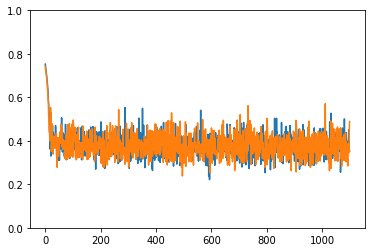

In [61]:
plt.plot(history_dict['loss_train'])
plt.plot(history_dict['loss_test'])
plt.ylim(0.0, 1.0)
plt.savefig('../reports/20190916.png')

In [33]:
data = dataset.__getitem__(0)

In [34]:
y = classifier(data['x'].unsqueeze(0))

In [35]:
y > 0.5

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]], dtype=torch.uint8)

In [36]:
data['y']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.])